# Code to explore the different components as found in all the datasets.
## First load the data
And remove some useless lines

In [1]:
%matplotlib inline  
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import plotly.express as px
import importlib
import seaborn as sns

In [6]:
if 'nux' in sys.platform:
    base_loc = '/tudelft.net/staff-umbrella/epimrfmcms/'
    if not os.path.exists(base_loc):
        base_loc = '/data/localhome/managtegaal/umbrella/epimrfmcms/'
else:
    base_loc = "Y:\\epimrfmcms\\"
    if not os.path.exists(base_loc):
        base_loc = "U:\\epimrfmcms\\"
res_loc = base_loc+'Results\\'
sum_res_loc = base_loc+'Results_overview\\'
if not os.path.exists(sum_res_loc):
    sum_res_loc = ''
df = pd.read_excel(sum_res_loc+'mc-res_abb_overview_.xlsx')
df = df.reset_index()
for key in ['Unnamed: 0', 'Unnamed: 0.1']:
    if key in df.columns:
        df = df.drop(key, axis=1)
        
col = list(df.columns)
marked_tissues = col[col.index('Notes')+1:]
df['Manheim'] = df['Subject'].str.contains('MRF')
print(marked_tissues)

['Strange effect', 'Myelin water', 'Fat/skull/outer', 'White matter', 'Grey matter Putamen', 'Grey matter', 'DAWM', 'Lesion', 'Low values-bundles', 'CSF', 'Boundary CSF/GM', 'Undefined']


Load boundary values from other function (or from file), so how we group the components and consider them to belong to certain tissues.

In [7]:
if os.path.exists('2020_09_14_group_and_calc_tissue_maps.py'):
    gactm = importlib.import_module('2020_09_14_group_and_calc_tissue_maps')
    with open("tissue_boundaries.txt","w") as f:
        f.write( str(gactm.bnds) )
    bnds = gactm.bnds
else:
    with open("tissue_boundaries.txt","r") as f:
        r = f.read()
    bnds = eval(r)
print(bnds)

import of compiled mssse module failed, using Python version
local_SPIJN not found
import of compiled fa_profile module failed, using Python version
{'Myelin water': [0, 200, 0, 200], 'Myelin water 2': [0, 500, 0, 500], 'White matter': [500, 1100, 0, 120], 'Grey matter': [1100, 2000, 0, 120], 'High Comp': [500, 2000, 500, 2000], 'Higher Comp': [800, 2500, 800, 2500], 'High Comp_2': [500, 2500, 500, 2500], 'CSF': [2500, 5000.0, 0, 5000.0]}


In [8]:
# Include tissue types with relaxation values
check = np.ones(len(df), dtype=bool)
df_tis = []
for tis, bnd in bnds.items():
    incl = np.logical_and.reduce([df.T1>bnd[0], df.T1<bnd[1],
                                 df.T2>bnd[2], df.T2< bnd[3]])
    check = np.logical_and(check, ~incl)
    df_tis.append(df.loc[incl].copy())
    df_tis[-1]['Tissue'] = tis
df_tis.append(df.loc[check].copy())
df_tis[-1]['Tissue'] = 'Not included'
df_tis = pd.concat(df_tis)
print(df_tis.columns)

Index(['index', 'Column1', 'T1', 'T2', 'Abundance', 'Fraction', 'Lbar',
       'Lbar_count', 'Subject', 'Subject_count', 'Healthy', 'Notes',
       'Strange effect', 'Myelin water', 'Fat/skull/outer', 'White matter',
       'Grey matter Putamen', 'Grey matter', 'DAWM', 'Lesion',
       'Low values-bundles', 'CSF', 'Boundary CSF/GM', 'Undefined', 'Manheim',
       'Tissue'],
      dtype='object')


Some explanation on the data; the data is from two locations therefore two different scanners and noise levels, therefore we played around with two different regularization rates (`Lbar`). To make comparison easy these are numbered as `Lbar_count`

For text purposes the code states `T2` but this should actually be `T2*` (or $T_2^*$)

In [9]:
labels = {'T2':'$T_2^*$ (ms)', 'T1' : '$T_1$ (ms)'}

### Plot all the matched components, with colors based on the groups

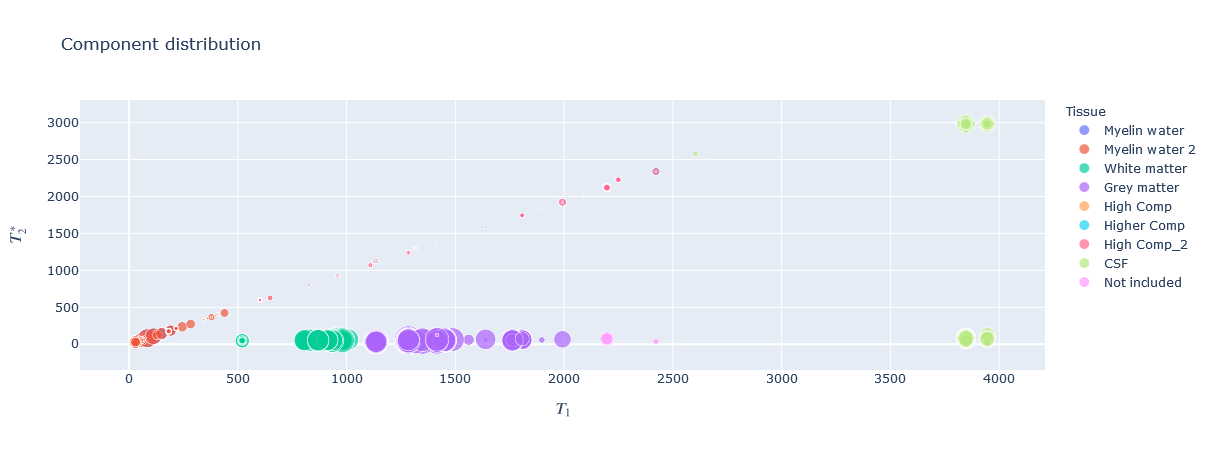

In [120]:
fig = px.scatter(df_tis.query('Lbar_count==1'), x='T1', y='T2', color="Tissue", 
                 size='Fraction', title='Component distribution', hover_data=['Subject'], labels=labels)
# fig.show()
# fig = px.scatter(df_tis.query('Lbar_count==1'), x='T1', y='T2',
#                  size='Fraction')
fig.layout.hovermode = 'closest'
fig.show()


### Annimate per subject. Works slightly buggy 

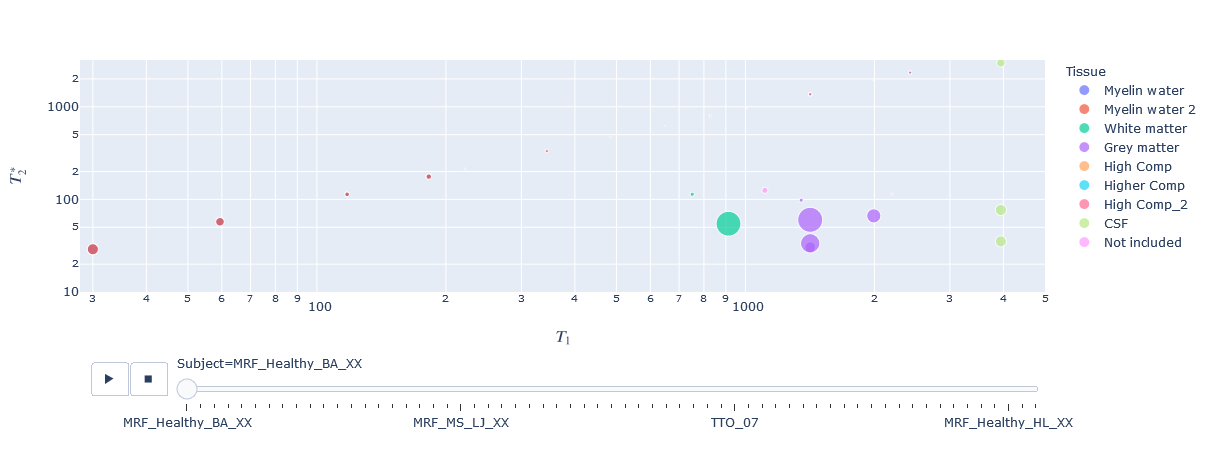

In [127]:
# .query('Lbar_count==1')
dfff = df_tis.query('Lbar==11')
fig = px.scatter(dfff, x='T1', y='T2', color="Tissue",
                 size='Fraction', facet_col='Lbar_count' if 5 in dfff['Lbar'].values else None,
                 animation_frame='Subject', range_x=[28, 5e3], range_y=[10,3.2e3] ,
                 log_x=True, log_y=True, labels=labels
                )
fig.show()
fig_annimation_0 = fig

So, as we can see. MRF_Healthy_SR_XX_onlyMRF_20180630 is rubbish, so we will have to take that one out.

In [12]:
filter_subjects='MRF_Healthy_SR_XX_onlyMRF_20180630'
filter_text = f'Subject!="{filter_subjects}"'
print(len(df_tis.query(filter_text)) - len(df_tis))

-125


## Tissue marking?
Let's see how the tissues as marked by me matches with the T1, T2 values.

In [115]:
from ipywidgets import widgets, interact, interactive_output, interact_manual
from IPython.display import display 
df_v = df_tis.query(filter_text)
def filter_per_tissue(v, and_or = 'Or', df_vv = None):
    if df_vv is None:
        df_vv = df_v
    if isinstance(v, str):
        return df_vv[df_vv[v]==1]
    else:
        red_f = np.logical_or if and_or=='Or' else np.logical_and
        if and_or == 'Or':
            l = []
            for vv in v:
                l.append((df_vv[df_vv[vv]==1]).copy())
                l[-1]['Marked_tissue'] = vv
            return pd.concat(l)
        else:
            return df_vv[np.logical_and.reduce([df_vv[vv]==1 for vv in v])]
        
def plot_per_tis(v, and_or='Or'):
    fig = px.scatter(filter_per_tissue(v, and_or), x='T1', y='T2', color="Tissue", hover_data=['Subject'],
                     size='Fraction', facet_col='Lbar_count', title=str(v), log_x=True, log_y=True,
                     labels=labels, symbol='Marked_tissue' if and_or=='Or' else None, )
    fig.show()
    return fig


def joint_plot_per_tis(v, and_or = 'Or', lbc=1):
    fig = sns.jointplot(data=filter_per_tissue(v, and_or).query('Lbar_count==@lbc'),
                        x='T1', y='T2', kind='hex' )
    return fig
    

sel_subj = widgets.SelectMultiple(options=marked_tissues, description='Tissue', value = (marked_tissues[1],))
and_or_or = widgets.RadioButtons(options=['Or', 'And'], description = 'How to combine selected tissues')
lbv = widgets.RadioButtons(options = [0,1], description = 'Lbar count selection')
ui = widgets.HBox([sel_subj, and_or_or, lbv])
# sns.relplot(data=filter_by_subject(v), x='T1', y='T2', hue='Tissue')
# interact(filter_by_subject)

io_ppt = interactive_output(plot_per_tis, dict(v=sel_subj, and_or = and_or_or))
io_jppt = interactive_output(joint_plot_per_tis, dict( v=sel_subj, and_or = and_or_or, lbc=lbv))
# display(sel_subj, and_or_or, io_ppt, io_jppt)
display(ui, io_ppt, io_jppt)



Output()

Output()

In [69]:
def show_per_tis(v, and_or = 'Or'):
    sel_v = filter_per_tissue(v, and_or)
    print(len(sel_v))
    r = []
    for t in ['T1', 'T2']:
        r.append( px.histogram(sel_v, x=t,y='Fraction', color="Tissue", hover_data=['Subject'],
                      facet_col='Lbar_count', title=str(v), log_x=False, labels=labels, marginal='box') )
        r[-1].show()
    
    
ii=interact(show_per_tis, v=sel_subj, and_or = and_or_or)

interactive(children=(SelectMultiple(description='Tissue', index=(4,), options=('Strange effect', 'Myelin wate…

Calculate mean and std values per marked tissue, to get some more impressions of the ranges.
We want to use the filtered `df` here without the added box-based tissue groups.

In [119]:
df_f = df.query(filter_text)

vv = []
res = []
for tis in marked_tissues:
    df_ff = filter_per_tissue((tis,),'Or', df_f).groupby(['Lbar_count']).agg([np.mean, np.std])[['T1','T2']]
    vv.append(filter_per_tissue((tis,),'Or', df_f)[['T1','T2', 'Lbar_count']])
    res.append(df_ff.reset_index())
    res[-1]['Tis']=tis
    vv[-1]['Tis']=tis
#     sns.jointplot(data=vv[-1],x='T1', y='T2' )

vv = pd.concat(vv)
# px.density_heatmap(vv, x='T1', y='T2', facet_col='Tis', facet_col_wrap=3, range_y=(30, 3e3), range_x=(30, 3e3))
print(pd.concat(res))



  Lbar_count           T1                       T2               \
                     mean         std         mean          std   
0          0  1209.241316  298.651090    46.684796    10.594787   
1          1  1638.451599  500.717141   982.062826  1331.219722   
0          0   293.648761  254.575794   186.575030   218.950555   
1          1   281.015515  347.277453   204.343641   283.641640   
0          0   220.177059  292.743774   194.646984   176.169396   
1          1   244.759613  337.234877   227.199200   266.623046   
0          0   897.565239  117.659603    73.849632   131.547193   
1          1   957.567668   80.498693    53.885929     4.593739   
0          0  1242.242085  124.414690    29.066391     5.433783   
1          1  1223.306067   93.295755    36.618070     4.201585   
0          0  1416.276273  242.891284    65.753559   112.403697   
1          1  1469.937883  200.138365    90.132938   257.874423   
0          0  1030.811712  248.971786   970.058766   304.19765

## Size of components

Let's check the size of the components, how are those distributed and which can be disregarded as very small? Should help in plot of counting tissues

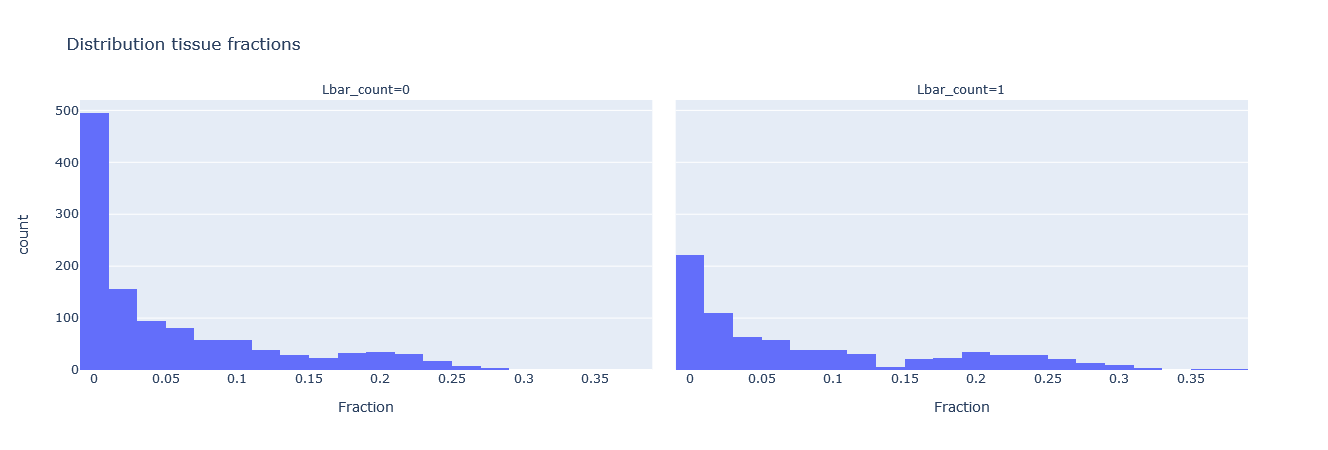

In [15]:
fig = px.histogram(df.query(filter_text), x='Fraction', title='Distribution tissue fractions',
                  facet_col='Lbar_count', nbins=20)
fig.show()

Thus with increasing regularization we see an increase in almost non-used componenents.

### Number of tissues per subjects
Check whether there is a difference in number of tissue between healthy and MS

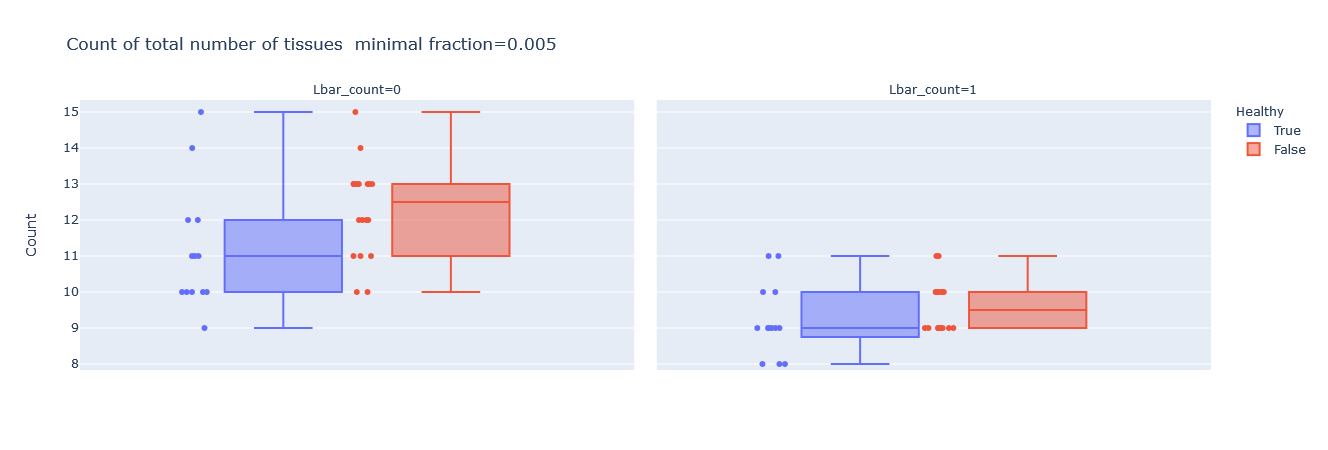

In [16]:
fr = .005
count_tot_tis = df.query(filter_text).query(f'Fraction>{fr}').groupby(['Subject', 'Healthy', 'Lbar_count', 'Manheim','Lbar'])
number_of_tissue = count_tot_tis.count().reset_index()
number_of_tissue['Count'] = number_of_tissue['Fraction']
boxplot_1 = px.box(number_of_tissue.query('Manheim'),y= 'Count', color='Healthy', facet_col='Lbar_count',
                   hover_name='Subject', points='all', title=f'Count of total number of tissues\n minimal fraction={fr}')
boxplot_1.show()

Tissue          Lbar_count
CSF             0             3.983871
                1             3.032258
Grey matter     0             3.322581
                1             2.419355
High Comp       0             2.580645
                1             1.354839
High Comp_2     0             3.177419
                1             2.129032
Higher Comp     0             2.000000
                1             1.596774
Myelin water    0             3.709677
                1             1.806452
Myelin water 2  0             5.403226
                1             3.129032
Not included    0             1.043478
                1             0.065217
White matter    0             1.951613
                1             1.354839
Name: Count, dtype: float64


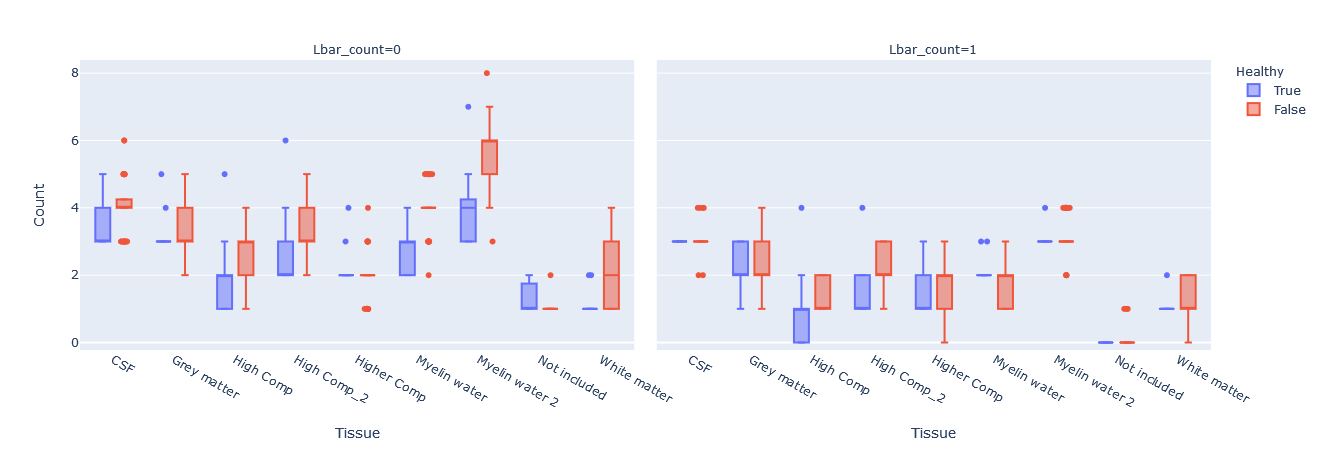

In [17]:
%matplotlib widget  
# %% Check num
gr_Tissue = df_tis.query(filter_text).groupby(['Tissue', 'Subject','Lbar_count'])
number_of_tissue = gr_Tissue.count().unstack(fill_value=0).stack().reset_index()
number_of_tissue['Count'] = number_of_tissue['Fraction']
number_of_tissue['Manheim'] = number_of_tissue['Subject'].str.contains('MRF')
number_of_tissue['Healthy'] = number_of_tissue['Subject'].str.contains('Heal')
print(number_of_tissue.groupby(['Tissue','Lbar_count']).mean()['Count'])

boxplot = px.box(number_of_tissue,x='Tissue',y= 'Count', color='Healthy',
                 facet_col='Lbar_count', hover_name='Subject', title='Count number of tissues'
                 )
boxplot.update_traces(jitter=0.5)
boxplot.show()

## Weighted T1 and T2*
Try to visualize the weighted mean T1 and T2* per volunteer and how it differs per subject

Subject!="MRF_Healthy_SR_XX_onlyMRF_20180630"


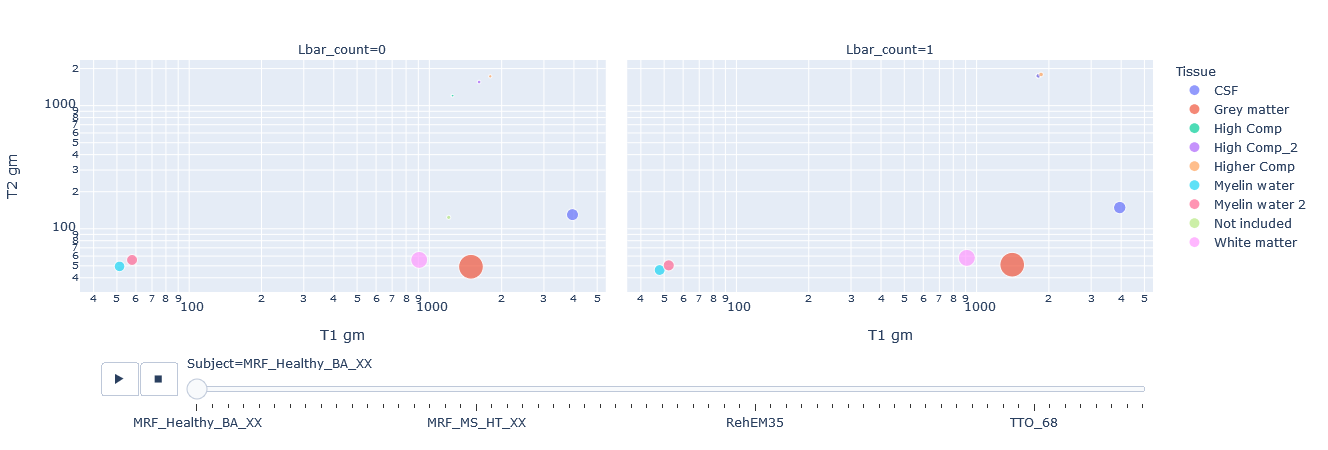

In [18]:
print(filter_text)
def gem_mean(group, t, w):
    return np.prod(group[t]**group[w])**(1/np.sum(group[w]))

T1gm = gr_Tissue.apply(gem_mean, 'T1', 'Fraction').unstack(fill_value=1e3).stack()
T2gm = gr_Tissue.apply(gem_mean, 'T2', 'Fraction').unstack(fill_value=1e3).stack()
T1gm.name = 'T1 gm'
T2gm.name = 'T2 gm'
frac = gr_Tissue.sum()['Fraction'].unstack(fill_value=0).stack()
frac.name='Fraction'
df_gm = pd.concat([T1gm, T2gm, frac], axis=1).reset_index()
fig = px.scatter(df_gm, x='T1 gm', y='T2 gm',color='Tissue',
                 animation_group='Tissue', size='Fraction',
             facet_col='Lbar_count', log_y=True,log_x=True,
                animation_frame='Subject')
fig.show()
fig_annimation = fig

## Check differences between Manheim and Barca data
How are those distributions different?
They used slightly different dictionaries we can see now...

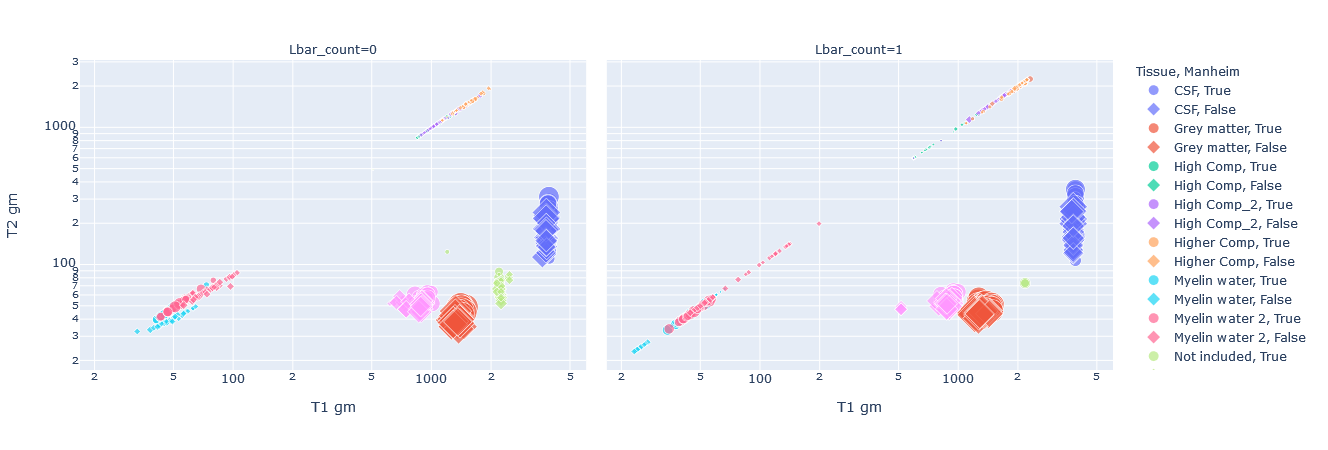

In [19]:
df_gm['Manheim'] = df_gm['Subject'].str.contains('MRF')
df_gm['Healthy'] = df_gm['Subject'].str.contains('Heal')
fig = px.scatter(df_gm, x='T1 gm', y='T2 gm',color='Tissue',
                 size='Fraction',
             facet_col='Lbar_count', log_y=True,log_x=True,
                 hover_name='Subject', symbol='Manheim'
                )
fig.show()

So most T1 and T2* values stay in the same ranges.

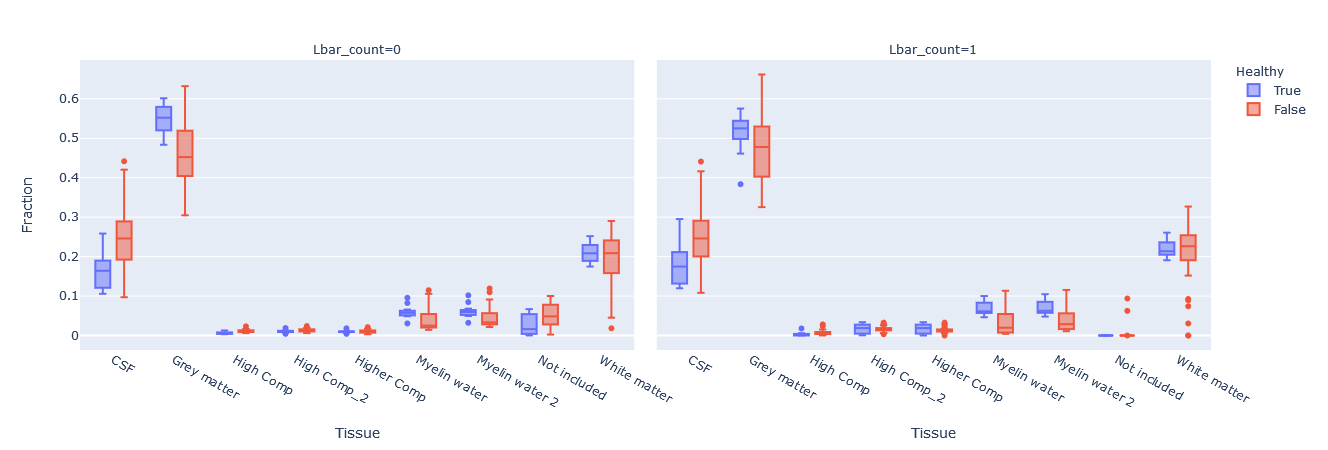

Myelin water 0 Ttest_indResult(statistic=-3.0239720347519925, pvalue=0.0036678058747841953)
Myelin water 2 0 Ttest_indResult(statistic=-2.6250345572208262, pvalue=0.010974877903424487)
Grey matter 0 Ttest_indResult(statistic=-3.8718303701205543, pvalue=0.00026932835967517153)
High Comp 0 Ttest_indResult(statistic=5.145721417042944, pvalue=3.0952451367742807e-06)
High Comp_2 0 Ttest_indResult(statistic=2.376418885117719, pvalue=0.020689908825336785)
CSF 0 Ttest_indResult(statistic=3.540384979179561, pvalue=0.0007792734403849237)
Myelin water 1 Ttest_indResult(statistic=-4.455125122722113, pvalue=3.722207463032952e-05)
Myelin water 2 1 Ttest_indResult(statistic=-4.264043191330994, pvalue=7.21784752934738e-05)
High Comp 1 Ttest_indResult(statistic=2.498365993145659, pvalue=0.015234115419844535)
CSF 1 Ttest_indResult(statistic=3.133427916055934, pvalue=0.0026723801818967267)


In [20]:
from scipy import stats
# .query('Tissue=="CSF"')
df_gm['Manheim'] = df_gm['Subject'].str.contains('MRF')
df_gm['Healthy'] = df_gm['Subject'].str.contains('Heal')

fig = px.box(df_gm,x='Tissue', y='Fraction',color='Healthy',
                facet_col='Lbar_count'
                )
fig.show()
fr_gr = df_gm.groupby(['Tissue','Healthy','Lbar_count'])
for l in range(2):
    for tis in bnds:
        ttest_res = stats.ttest_ind(fr_gr.get_group((tis, False, l))['Fraction'], fr_gr.get_group((tis, True, l))['Fraction'])
        if ttest_res.pvalue <.05:
            print(tis, l, ttest_res)


Two options here;
1. we still have some datasets with minor errors in them with respect to the tissue fraction.
2. There are significant differences in CSF amount, myelin water and (sometimes) high component...

I think there aren't that many errors in there. Especially the CSF component is accurate. 

Let's zoom in on the High component, what are the T1, T2* values most used. We can simplify this a bit by only considering T1 (since T1==T2* very often)

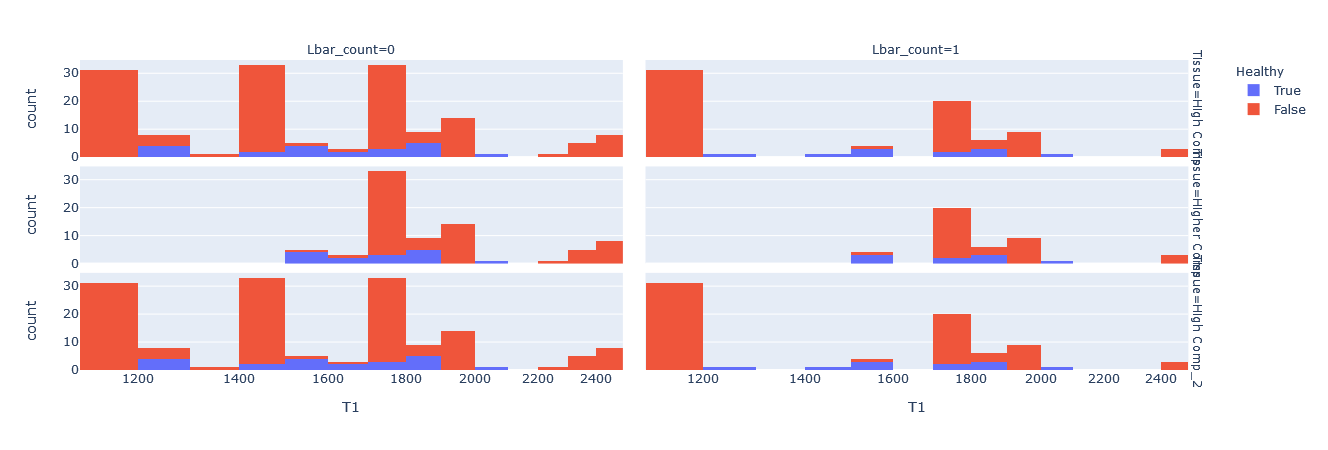

In [21]:
df_high = df_tis.query(filter_text)[df_tis.query(filter_text)['Tissue'].str.match('High*')]
fig = px.histogram(df_high, x='T1', facet_col='Lbar_count', color='Healthy', facet_row='Tissue', log_x=True)
fig.show()

The following experiment is not working...

In [22]:
if 0:
    from ipywidgets import interactive, interact, widgets
    # fig = plt.figure()
    df_v = df_tis.query(filter_text)
    def filter_by_subject(v):
        return df_v[df_v['Subject']==v]

    class plot_per_subj_class():
        def __init__(self):
            pass
            self.selection = widgets.SelectionSlider(options=np.unique(df_v.Subject), description='Subject')
            self.selection.observe(self.handle_submit)
            self.fig = self.plot_per_subj(self.selection.value)
            display(self.selection, self.fig)
        def plot_per_subj(self, v = None):
            if v is None:
                v = self.selection.value
            fig = px.scatter(filter_by_subject(v), x='T1', y='T2', color="Tissue",
                             size='Fraction', facet_col='Lbar_count', title=v, log_x=True, log_y=True)
            return fig
        def handle_submit(self, v):
            self.fig.title = v
            for d in self.fig.data:
                values = filter_by_subject(self.selection.value).query(f'Tissue=="{d.name}"')
                d.x = values.T1
                d.y = values.T2
            self.fig.update()
    #         self.fig = self.plot_per_subj(self.selection.value)
    #         display(self.fig)


    f = plot_per_subj_class()

Slightly different plot of the components. Also fun.

In [23]:
from ipywidgets import widgets, interact
df_v = df_tis.query(filter_text)
def filter_by_subject(v):
    return df_v[df_v['Subject']==v]
def plot_per_subj( v):
    fig = px.scatter(filter_by_subject(v), x='T1', y='T2', color="Tissue",
                     size='Fraction', facet_col='Lbar_count', title=v, log_x=True, log_y=True, labels=labels)
    return fig

sel_subj = widgets.SelectionSlider(options=np.unique(df.Subject), description='Subject')
# sns.relplot(data=filter_by_subject(v), x='T1', y='T2', hue='Tissue')
# interact(filter_by_subject)
interact(plot_per_subj, v=sel_subj)

interactive(children=(SelectionSlider(description='Subject', options=('MRF_Healthy_BA_XX', 'MRF_Healthy_CYL_XX…

<function __main__.plot_per_subj>